# <center>Анализ данных и подготовка плана действий по удержанию клиентов сети фитнес-центров</center>

#### Задачи:
* научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    * 1) выделить целевые группы клиентов;
    * 2) предложить меры по снижению оттока;
    * 3) определить другие особенности взаимодействия с клиентами.

#### Содержание:<a id="content"></a>
1. [Загрузка данных](#info)
2. [EDA](#eda)
3. [Обучение модели](#model)
4. [Кластеризация пользователей](#cluster)
5. [Выводы и рекомендации](#summary)

## Загрузка данных:<a id="info"></a>
[вернуться к содержанию](#content)

#### Импорты:

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Датасет:

In [4]:
gym = pd.read_csv('/datasets/gym_churn.csv')

In [5]:
display(gym.head())
display(gym.shape)
display(gym.info())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


(4000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


None

**Текущие поля в датасете:**
* 'Churn' — факт оттока в текущем месяце;

**Данные пользователя за предыдущий до проверки факта оттока месяц:**
* 'gender' — пол
* 'Near_Location' — проживание или работа в районе, где находится фитнес-центр
* 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
* 'Promo_friends' — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
* 'Phone' — наличие контактного телефона
* 'Age' — возраст
* 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах)

**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**
* 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
* 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах)
* 'Group_visits' — факт посещения групповых занятий
* 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента
* 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц
* 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

#### Вывод:
В датафрейме представлены 4000 строк и 14 столбцов. Данные полные, типизация корректна, кроме стобца 'Month_to_end_contract', его следует перевести в int. Для удобства следует привести названия столбцов к нижнему регистру, проверить на дубликаты.

#### Предобработка данных:

Изменим тип столбца 'Month_to_end_contract':

In [6]:
gym['Month_to_end_contract'] = gym['Month_to_end_contract'].astype('int')

## Комментарий наставника
<span style="color:green">Хорошо.</span>



Приведем названия столбцов к нижнему регистру:

In [7]:
gym.columns = gym.columns.str.lower()

Проверим на дубликаты:

In [8]:
gym.duplicated().sum()

0

## EDA (исследовательский анализ данных)<a id="eda"></a>
[вернуться к содержанию](#content)

Методом `describe()` изучим средние и страндартные отклонения:

In [9]:
gym.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


* Клиенты в выборке равномерно разделены по полу
* Большинство клиентов живет рядом с клубом
* Половина клиентов являются сотрудниками компаний-партнеров
* 30% клиентов оплатили свой первый абонемент в рамках акции "приведи друга"
* Большинство указали мобильный телефон
* Больше половины клиентов покупают абонемент на 1 месяц
* Около половины клиентов посещают групповые занятия
* Средний возраст клиента - 29 лет
* В среднем, на другие услуги клуба клиент тратит 147 у.е.
* Среднее "время жизни" клиента - 3-4 месяца
* Средняя частоста посещений в неделю - 1-2 раза

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался:

In [10]:
gym.groupby('churn').agg('mean').T

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток):

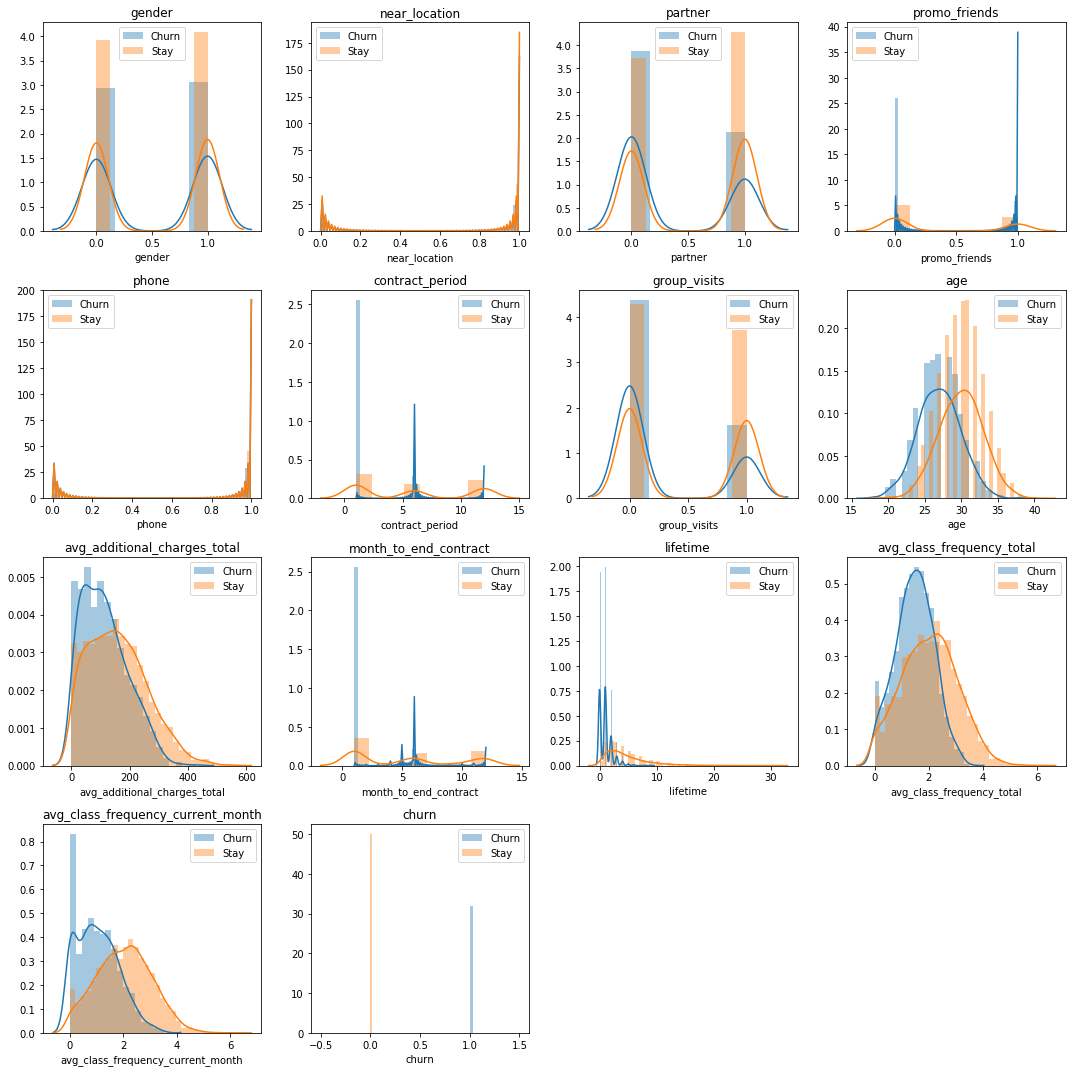

In [11]:
plt.subplots(figsize=(15, 15))
plots_in_row = 4

for i, col in enumerate(gym.columns.values):
    sns.distplot(gym.query('churn == 1')[col], label='Churn', ax=plt.subplot(len(gym.columns.values) // plots_in_row + 1, plots_in_row, i + 1))
    sns.distplot(gym.query('churn == 0')[col], label='Stay')
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

#### Вывод:
* Пол клиента не влияет на факт оттока
* Клиенты, находящиеся близко к клубу, остаются чаще
* Клиенты-сотрудники компаний-партнеров остаются чаще
* Клиенты воспользовавшиеся акцией "пригласи друга" остаются чаще
* Клиент, покупающий абонемент на короткое время уходит чаще
* Клиенты, посещающие групповые занятия остаются намного чаще
* Медианный возраст ушедшего клиента - 27 лет, оставшегося - 30
* Клиенты, посещающие клуб менее 2х раз в неделю уходят чаще
* Клиент, платящий за другие услуги клуба менее 200 у.е. уходит немного чаще.

In [12]:
gym.groupby('churn').agg('mean')['partner'].T

churn
0    0.534195
1    0.355325
Name: partner, dtype: float64

Построим матрицу корреляций:

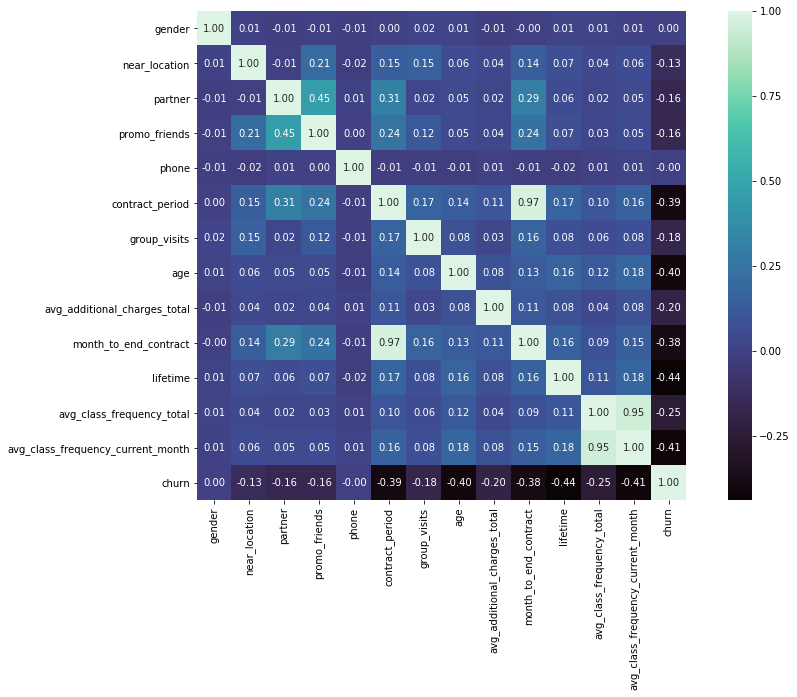

In [13]:
plt.figure(figsize=(15, 9))
sns.heatmap(gym.corr(), annot = True, fmt='.2f', square=True, cmap="mako")
plt.show()

Сильно скореллировали признаки:
* `avg_class_frequency_current_month` и `avg_class_frequency_total`
* `contract_period` и `month_to_end_contract`

Возможно, это связанно с тем, что большинство клиентов подписывают контракты на 1 месяц. Т.к. мы будем строить модель логистической регрессии, удалять эти признаки для борьбы с мультиколлинеарностью не нужно. 

Корреляций факта оттока с другими признаками нет. 

## Модель прогнозирования оттока пользователей<a id="model"></a>
[вернуться к содержанию](#content)

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце:

In [14]:
#разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym.drop(['churn'], axis=1)
y = gym['churn']

#разделяем модель на обучающую и валидационную выборку в соотношении 80:20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#### Логистическа регрессия:

In [15]:
#зададим алгоритм логистической регрессии для модели
logr_model = LogisticRegression(random_state=0)

#обучим модель
logr_model.fit(X_train, y_train)

#сделаем прогнозы
logr_predictions = logr_model.predict(X_test)
logr_probabilities = logr_model.predict_proba(X_test)[:,1]

#### Случайный лес:

In [16]:
#зададим алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(random_state=0)

#обучим модель
rf_model.fit(X_train, y_train)

#сделаем прогнозы
rf_predictions = rf_model.predict(X_test)
#rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

#### Сравним модели:

In [17]:
print('Метрики для алгоритма логистической регрессии:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, logr_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, logr_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logr_predictions)))
print()
print('Метрики для алгоритма случайного леса:')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики для алгоритма логистической регрессии:
Accuracy: 0.93
Precision: 0.86
Recall: 0.83

Метрики для алгоритма случайного леса:
Accuracy: 0.91
Precision: 0.83
Recall: 0.78


Модель логистической регрессии показывает лучший результат в сравнении с моделью случайного леса.

## Кластеризацию пользователей<a id="cluster"></a>
[вернуться к содержанию](#content)

In [18]:
#создадим объект класса StandardScaler и применим его к обучающей выборке
sc = StandardScaler()
x_sc = sc.fit_transform(gym.drop(['churn'], axis=1))

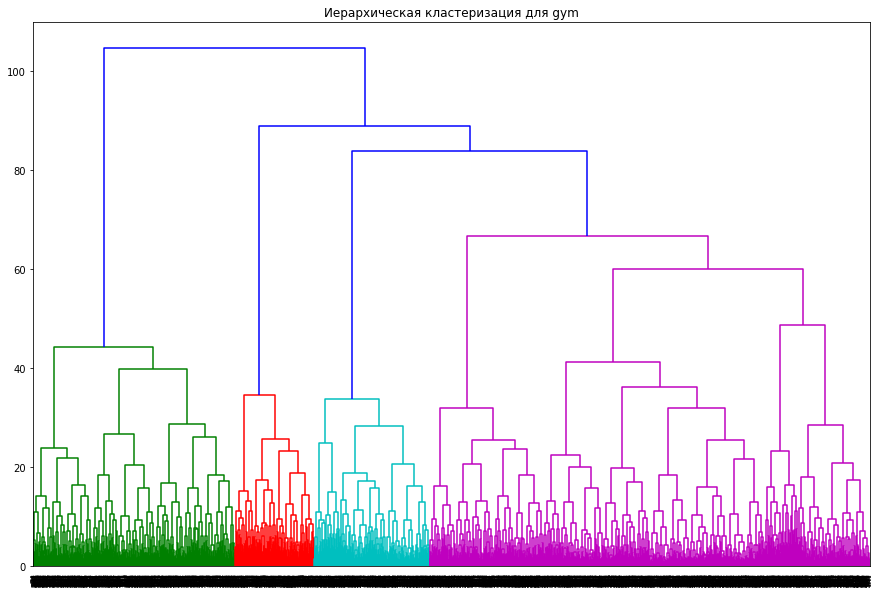

In [19]:
#отрисуем график кластеризации пользователей
linked = linkage(x_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация для gym')
plt.show()

Посмотрим на средние значения признаков для кластеров:

In [20]:
#задаём модель KMeans с числом кластеров 5
km = KMeans(n_clusters = 5, random_state = 0)

#прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_sc)

# сохраняем метки кластера в поле нашего датасета
gym['cluster_km'] = labels

# выводим статистику по средним значениям наших признаков по кластеру
gym_clusters = gym.groupby('cluster_km').mean().T

Можно заметить, что значения близости к клубу во 2м класетере равно нулю, то есть все клиенты этого кластера находятся близ клуба. Также можно отметить, что алгоритм отнес к 0му кластеру клиентов, которые берут абонемент на продолжительный срок, на 6 или 12 месяцев.

Построим распределения признаков для кластеров:

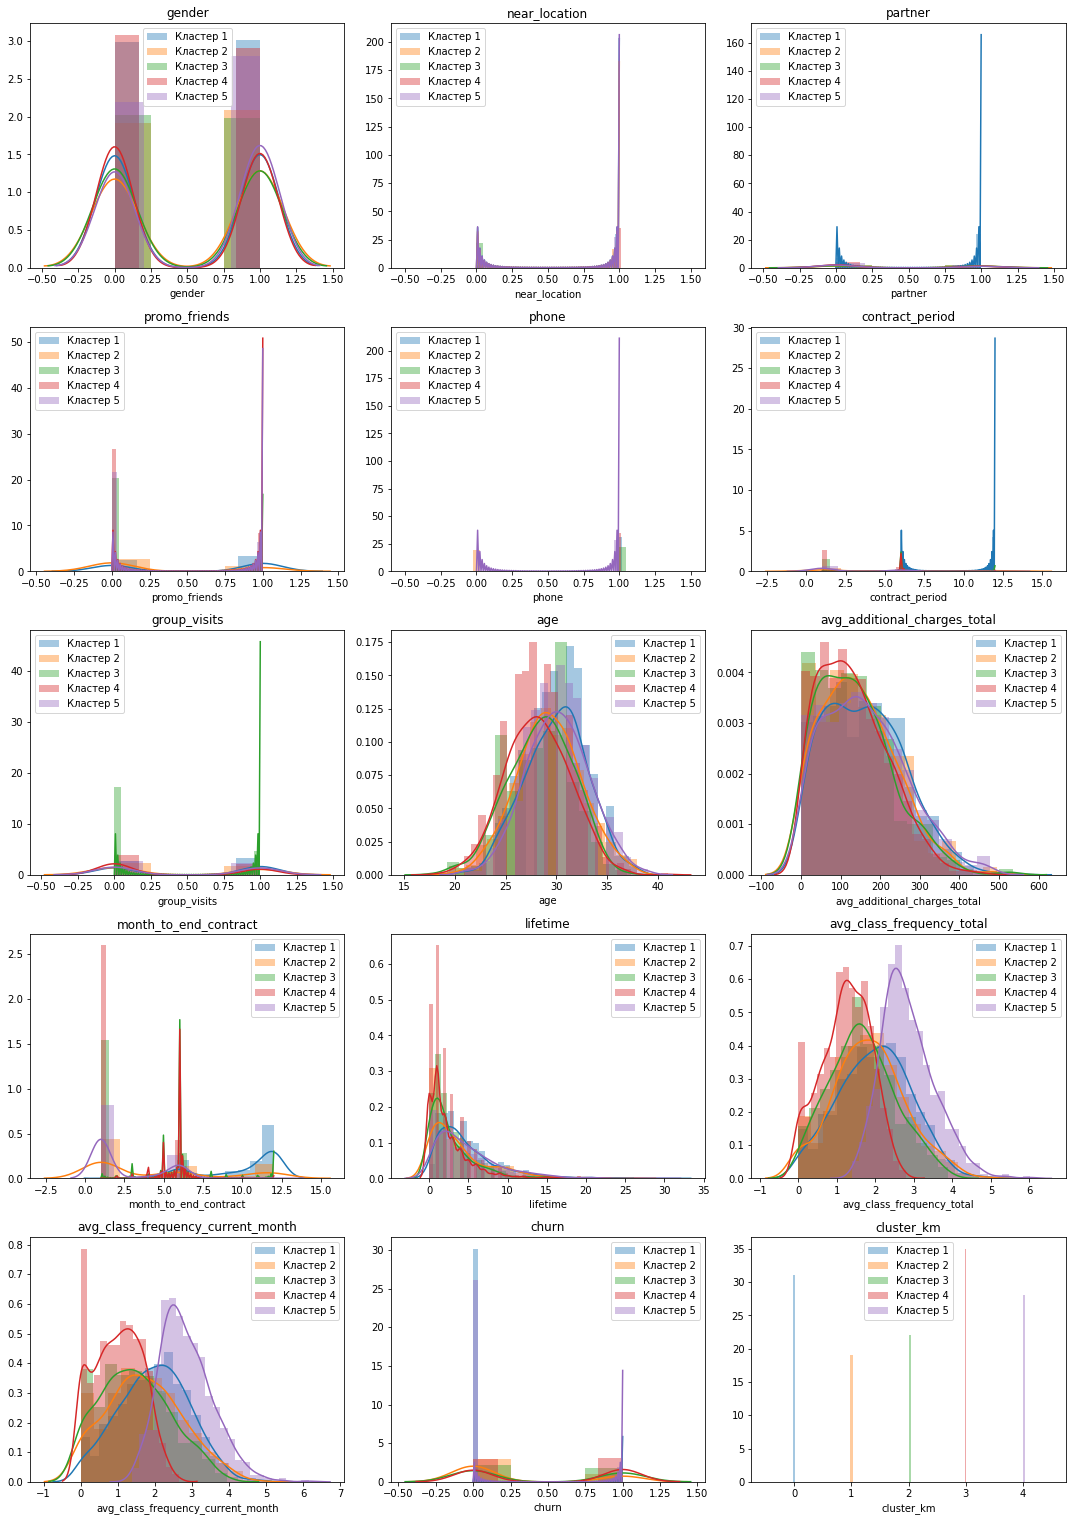

In [21]:
plt.subplots(figsize=(15, 25))
plots_in_row = 3

for i, col in enumerate(gym.columns.values):
    sns.distplot(gym.query('cluster_km == 0')[col], label='Кластер 1', ax=plt.subplot(len(gym.columns.values) // plots_in_row + 1, plots_in_row, i + 1))
    sns.distplot(gym.query('cluster_km == 1')[col], label='Кластер 2')
    sns.distplot(gym.query('cluster_km == 2')[col], label='Кластер 3')
    sns.distplot(gym.query('cluster_km == 3')[col], label='Кластер 4')
    sns.distplot(gym.query('cluster_km == 4')[col], label='Кластер 5')
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()

In [22]:
churn_by_cluster = gym.groupby('cluster_km')['churn'].mean().reset_index()
churn_by_cluster['churn'] = churn_by_cluster['churn'].map('{:,.0%}'.format)
churn_by_cluster

,cluster_km,churn
0,0,3%
1,1,27%
2,2,44%
3,3,51%
4,4,7%


Самый большой отток произошел в кластере 3 - 51% клиентов не вернулись. Меньше всего ушло клиентов из 0го кластера - 3%. Средний процент оттока - 26%

#### Вывод:<a id="churn_client_portrait"></a>
Портрет ушедшего клиента:
* Женщина или мужчина
* Живет или работает в отдаленности от клуба
* Не сотрудник компаний-партнеров
* Не пришел по акции "приведи друга"
* Имеет контактный телефон
* Покупает абонемент на месяц или 3
* Не посещает групповые занятия
* Средний возраст - 28 лет
* Тратит на доп. услуги менее 140 у.е.
* Посещает клуб 1 или, реже, 2 раза в неделю
* Среднее "время жизни" - 1 месяц

## Выводы и базовые рекомендации по работе с клиентами:<a id="summary"></a>
[вернуться к содержанию](#content)

#### Общие выводы:
* Среди клиентов поровну мужчин и женщин
* Большинство клиентов живут или работают рядом с фитнес-клубом
* Половина посетителей - сотрудники компаний-партнеров
* 90% клиентов предоставили свой контактный телефон
* Более половины клиентов преобрели абонемент на 1 месяц
* Половина клиентов посещают групповые занятия
* Средний возраст клиента - 29 лет
* В среднем, на другие услуги клуба клиент тратит 147 у.е.
* Средняя частоста посещений в неделю - 1-2 раза
* Среднее "время жизни" клиента - 3-4 месяца

#### Выводы по итогам кластеризации:
* [Портрет ушедшего клиента](#churn_client_portrait)
* Средний процент оттока - 26%
* Факторы влияющие на отток:
    * Отдаленность от клуба
    * Клиент не является сотрудником компаний-партнеров
    * Клиент не пришел по акции "приведи друга"
    * Короткий срок абонемента
    * Непосещение групповых занятий
    * Посещение клуба 1, либо реже, 2 раза

#### Рекомендации:
Стоит больше внимания уделять новым клиентам, повысить их удержание и всячески мотивировать к посещению клуба. Рекомендуется к рассмотрению возможности введения дополнительных льгот/акций для новых клиентов клуба с упором на увеличение срока абонемента, посещение групповых занятий и системное посещение фитнес-клуба 2 и более раз в неделю. 